In [4]:
import torch
import torch.nn as nn
import numpy as np
import math
from scipy.interpolate import interp1d
import csv
from datetime import datetime, timedelta
from plyfile import PlyData, PlyElement
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from ThermoONet_architecture import Branch
from ThermoONet_architecture import SELayer
from ThermoONet_architecture import SELayer_w
from ThermoONet_architecture import Branch1
from ThermoONet_architecture import Branch2
from ThermoONet_architecture import Branch3

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [5]:
num_sensors = 128
branch = Branch(num_sensors).cuda()
# Read the trained network
branch = torch.load("Network/network_accurate.pkl")

In [6]:
# Z-score parameters
def Z_Score(x):
    mean = np.mean(x)
    std = np.std(x)
    return mean, std, (x-mean)/std

mean, std = 0.5216620832565283, 0.16037000058696135
mean_p1, std_p1 = 5.587696141721031, 1.8642376418421138
mean_p2, std_p2 = 0.9012508495757381, 0.057731154082425275
mean_p3, std_p3 = 0.011181149021523971, 0.004995541538499874
mean_p4, std_p4 = 16.542181636792183, 12.499430941576392
mean_p5, std_p5 = 16.524861547108635, 12.931041392620573
mean_p6, std_p6 = 0.45722424339279366, 0.306981614080625
mean_p7, std_p7 = 0.058400414325008906, 0.030512679311208945
mean_p8, std_p8 = 0.06281489233220064, 0.034735621144138

# Some functions
def ZHK(p_global3, p_ice3, u):
    mb = 3e-26
    kb = 1.38e-23
    psi = 1/(1+0.14*p_global3/0.001)

    a = 3.23e+12
    b = 6134.6
    c0 = 0.146
    c1 = 0.854
    c2 = 57.78
    c3 = 11580

    Pv = a*np.exp(-b/(u))
    alpha = c0+c1/(1+np.exp(c2-c3/(u)))
    Z_HK = psi*p_ice3*alpha*Pv*np.sqrt(mb/(2*np.pi*kb*(u)))
    return Z_HK

def utc_to_julian(utc_time):
    if not isinstance(utc_time, datetime):
        raise ValueError("must datetime object")
    julian_day = utc_time.toordinal()+1721424.5+(utc_time.hour + utc_time.minute/60+utc_time.second/3600)/24
    return julian_day

def julian_to_utc(julian_day):
    if not isinstance(julian_day, (float, int)):
        raise ValueError("must float or int")

    z = int(julian_day+0.5)
    f = julian_day+0.5-z
    if z < 2299161:
        a = z
    else:
        alpha = int((z-1867216.25)/36524.25)
        a = z+1+alpha-int(alpha/4)
    
    b = a+1524
    c = int((b-122.1)/365.25)
    d = int(365.25*c)
    e = int((b-d)/30.6001)
    
    day = b-d-int(30.6001 * e)+f
    month = e-(1 if e < 14 else 13)
    year = c-(4716 if month > 2 else 4715)
    
    hour = int((f*24))
    minute = int(((f*24)-hour)*60)
    second = int((((f*24)-hour)*60-minute)*60)

    return datetime(year, month, int(day), hour, minute, second)

def cartesian_to_spherical(x, y, z):
    r = math.sqrt(x**2+y**2+z**2)
    theta = math.acos(z/r)
    phi = math.atan2(y, x)
    if phi<0:
        phi = 2*np.pi+phi
    return r, theta, phi

def normal_vector(A, B, C):
    AB = B-A
    AC = C-A
    nv = np.cross(AB, AC)
    return nv/np.sqrt(np.sum(nv**2))

def center_vector(A, B, C):
    Cx = (A[0]+B[0]+C[0])/3
    Cy = (A[1]+B[1]+C[1])/3
    Cz = (A[2]+B[2]+C[2])/3
    return np.array([Cx, Cy, Cz])

def area_surface(A, B, C):
    v1 = B-A
    v2 = C-A
    cross_product = np.cross(v1, v2)
    area = 0.5*np.linalg.norm(cross_product)
    return area

In [7]:
"""Take 67P as test example"""
# Water production rate from the observations
with open('laeuteretal_prod.csv', newline='', encoding='utf-8') as file:
    reader = csv.reader(file)
    i = 0
    line = []
    for row in reader:
        if i>=2:
            line.append(list(map(float, row[0].split(';'))))
        i += 1
obwa = np.array(line)[:, 1:9]

In [8]:
# Orbit and spin state of 67P
filename = 'solar_position.txt'
with open(filename, 'r') as file:
    lines = file.readlines()
    lines = [line.strip() for line in lines]
orbit = []
for i in range(len(lines)-1):
    orbit.append(list(map(float, lines[i+1][21:].split()))[1:])
orbit = np.array(orbit)

orbit_sh = []
for i in range(len(orbit)):
    r, theta, phi = cartesian_to_spherical(orbit[i, 0], orbit[i, 1], orbit[i, 2])
    orbit_sh.append([r, theta, phi])
orbit_sh = np.array(orbit_sh)

time_orb = []
for i in range(len(lines)-1):
    year = list(map(int, lines[i+1][:4].split()))[0]
    month = list(map(int, lines[i+1][5:7].split()))[0]
    day = list(map(int, lines[i+1][8:10].split()))[0]
    hour = list(map(int, lines[i+1][11:13].split()))[0]
    minute = list(map(int, lines[i+1][14:16].split()))[0]
    second = list(map(int, lines[i+1][17:19].split()))[0]
    if second == 60:
        second -= 1
    cos_time = datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)
    time_orb.append(utc_to_julian(cos_time))
time_orb = np.array(time_orb)

looktabel = interp1d(time_orb, orbit_sh, kind='linear', axis=0)

cos_time = datetime(year=2014, month=8, day=1, hour=0, minute=0, second=0)
time_ru = []
start_time = utc_to_julian(cos_time)
for i in range(len(obwa)):
    delta_time = obwa[i, 0]-obwa[0, 0]
    present_time = start_time+delta_time
    time_ru.append(present_time)
time_ru_min = np.array(time_ru)

time_ru = []
start_time = utc_to_julian(cos_time)
for i in range(len(obwa)):
    delta_time = obwa[i, 2]-obwa[0, 0]
    present_time = start_time+delta_time
    time_ru.append(present_time)
time_ru_max = np.array(time_ru)

time_ru = []
start_time = utc_to_julian(cos_time)
for i in range(len(obwa)):
    delta_time = obwa[i, 1]-obwa[0, 0]
    present_time = start_time+delta_time
    time_ru.append(present_time)
time_ru_mean = np.array(time_ru)

In [9]:
# Shape and radiation of 67P (2868 facets)
file_path = 'cg-spc-shap8-v2.0-cheops-003k.ply'
plydata = PlyData.read(file_path)

points = plydata['vertex'].data
x = points['x']
y = points['y']
z = points['z']

faces = plydata['face'].data
vertex_indices = faces['vertex_index']

points_list = []
for i in range(len(x)):
    points_list.append([x[i], y[i], z[i]])
indices_list = []
for indices in vertex_indices:
    indices_list.append(indices)
points = np.array(points_list)
indices = np.array(indices_list)

asteroid_test1 = points
asteroid_test2 = indices

surface_element1 = []
for i in range(len(asteroid_test2)):
    surface_element1.append([asteroid_test1[int(asteroid_test2[i, 0]), :], \
                             asteroid_test1[int(asteroid_test2[i, 1]), :], asteroid_test1[int(asteroid_test2[i, 2]), :]])
surface_element = np.array(surface_element1)

nvs = []
ces = []
ars = []
for i in range(len(surface_element)):
    nv = normal_vector(surface_element[i, 0, :], surface_element[i, 1, :], surface_element[i, 2, :])
    ce = center_vector(surface_element[i, 0, :], surface_element[i, 1, :], surface_element[i, 2, :])
    ar = area_surface(surface_element[i, 0, :], surface_element[i, 1, :], surface_element[i, 2, :])
    nvs.append(nv)
    ces.append(ce)
    ars.append(ar)
nvs = np.array(nvs)
ces = np.array(ces)
ars = np.array(ars).reshape(len(surface_element), 1)

results = [None]*1
for j in range(1):
    filename = f'shadow_67P.pkl'
    with open(filename, 'rb') as file:
        results[j] = pickle.load(file)
        results[j] = [x for x in results[j] if x is not None]
results = np.concatenate([results[i] for i in range(1)])

results_list = []
num_faces = results[0](np.linspace(0, 2*np.pi, 128)).shape[0]
for i in range(len(results)):
    results_list.append(results[i](np.linspace(0, 2*np.pi, 128)))
results_array = np.transpose(np.array(results_list), (1, 0, 2))
zong3 = interp1d(np.linspace(0, np.pi, 64), results_array, kind='linear', axis=1)

orbit_s = looktabel(time_ru_mean)
num = len(orbit_s)
num_p = 12

function3 = zong3(orbit_s[:, 1])
interp = interp1d(np.linspace(0, 2*np.pi, 128), function3, kind='linear', axis=-1)

mid_yita = np.linspace(0, 2*np.pi, 128)[:, np.newaxis]+orbit_s[:, 2]
yita_list = np.linspace(0, 2*np.pi, num_p)
f_data = []
for i in range(num):
    interp = interp1d(np.linspace(0, 2*np.pi, 128), function3[:, i, :], kind='linear', axis=-1)
    for j in range(num_p):
        f_for = interp(np.mod(mid_yita[:, i]+yita_list[j], 2*np.pi))
        f_data.append(f_for.reshape(len(f_for), 128))
f_data = np.array(f_data).reshape(num, num_p, num_faces, 128)
f_test = torch.tensor(f_data).float().cuda()

In [10]:
# Calculation of water production rate
def ZHK(p_global3, p_ice3, u):
    mb = 3e-26
    kb = 1.38e-23
    psi = 1/(1+0.14*p_global3/0.001)

    a = 3.23e+12
    b = 6134.6
    c0 = 0.146
    c1 = 0.854
    c2 = 57.78
    c3 = 11580

    Pv = a*np.exp(-b/(u))
    alpha = c0+c1/(1+np.exp(c2-c3/(u)))
    Z_HK = psi*p_ice3*alpha*Pv*np.sqrt(mb/(2*np.pi*kb*(u)))
    return Z_HK

# params:
# [
# thickness of dust mantle (m)
# icy area fraction (%)
# sqrt(heat conductivity of dust mantle (W/mK))
# sqrt(heat conductivity of dust-ice mixture (W/mK))
# sqrt(product between the density of the dust mantle and the specific heat capacity (J/m^3K)*spin angular velocity (rad/s))
# ]
def water_production(params):
    omega = 2*np.pi/(12.4*3600)
    
    Te_list = []
    p_list = []
    for i in range(num):
        Guy_list = []
        p_global1 = np.sqrt(np.sqrt((1-0.05)*1357/(orbit_s[i, 0]/1.496e+8)**2))
        p_global = [p_global1, 1, params[0]]
        p_dust = [params[4], params[2]]
        p_ice = [8.388111692959722, params[3], params[1]]
        
        p_ice[0] = np.sqrt((1-p_ice[-1])*p_dust[0]**2+p_ice[-1]*2100*920*omega)

        p_data = np.array([p_global[0], p_global[1], p_global[2], p_dust[0], p_ice[0], p_ice[2], p_dust[1], p_ice[1]])
        Te_list.append(p_data[0]/(p_data[1]*5.67e-8)**(1/4))
        p_data = ((p_data-np.array([mean_p1, mean_p2, mean_p3, mean_p4, mean_p5, mean_p6, mean_p7, mean_p8])) \
                       /np.array([std_p1, std_p2, std_p3, std_p4, std_p5, std_p6, std_p7, std_p8]))
        p_list.append(p_data)
    p_data = np.array(p_list)
    Te = np.array(Te_list).reshape(num, 1)

    p_test = torch.tensor(p_data).float().cuda()
    output2 = branch.branch2(p_test[:, 1:8])
    output3 = branch.branch3(p_test[:, 0].unsqueeze(1))
    leakyrelu = nn.LeakyReLU(0.02)
    output23 = leakyrelu(branch.se(torch.mul(output2, output3)+0.001))

    WPR = []
    tem = []
    for i in range(num):
        Z_D_nump = []
        for j in range(num_p):
            output1 = branch.branch1(f_test[i, j])
            output = ((torch.mean(output1*output23[i], dim=-1)+0.01)*std+mean).detach().cpu().numpy()
            Guy = (output*Te[i]).reshape(1, len(f_for))
            Guy[np.where(Guy<0)] = -Guy[np.where(Guy<0)]

            Z_D = ZHK(p_global[-1], p_ice[-1], Guy)
            Z_D = np.sum(Z_D*ars.flatten(), axis=-1)
            Z_D_nump.append(Z_D)
        WPR.append(np.mean(np.array(Z_D_nump))*1e+6/3e-26)
        tem.append(Guy)
    WPR = np.array(WPR)
    tem = np.array(tem)
    return WPR, tem

gd_sol, tem = water_production([3.61079546e-03, 6.44077065e-03, 4.66889659e-02, 4.69151339e-02, 8.94414100e+00])

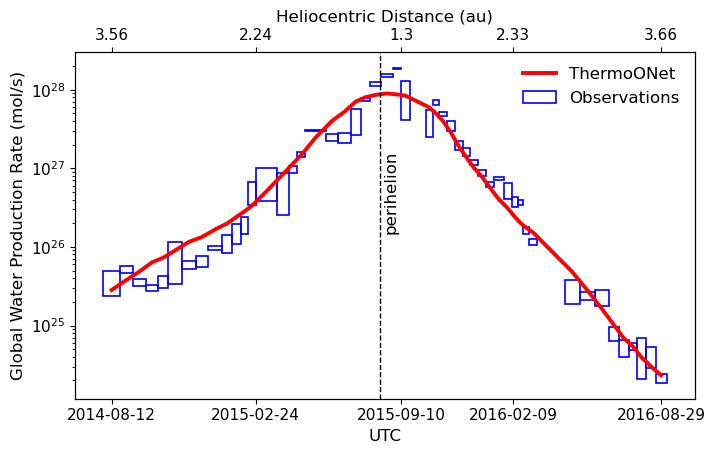

In [11]:
# Plot water production rate of 67P
interpx0 = interp1d(np.linspace(0, 1, len(obwa)), time_ru_mean)
interpx1 = interp1d(np.linspace(0, 1, len(obwa)), obwa[:, 4])

julian_plot_list0 = []
for i in range(len(obwa)):
    julian_plot_list0.append(julian_to_utc(time_ru_min[i]))
    
julian_plot_list1 = []
for i in range(len(obwa)):
    julian_plot_list1.append(julian_to_utc(time_ru_max[i]))
    
julian_plot_list2 = []
for i in range(len(obwa)):
    julian_plot_list2.append(julian_to_utc(time_ru_mean[i]))

num_tick = 5
time_plot = interpx0(np.linspace(0, 1, num_tick))
julian_plot_list = []
for i in range(num_tick):
    julian_plot_list.append(julian_to_utc(time_plot[i]))

fig, ax1 = plt.subplots(figsize=(8, 4.5))

for i in range(len(obwa)):
    x_min, x_max, y_min, y_max = julian_plot_list0[i], julian_plot_list1[i], obwa[i, -2], obwa[i, -1]
    rect = patches.Rectangle(
        (mdates.date2num(x_min), y_min),  # 转换为日期数值
        mdates.date2num(x_max)-mdates.date2num(x_min),  # 宽度也是日期差
        y_max-y_min,
        linewidth=1.2,
        edgecolor='b',
        facecolor='none'
    )
    ax1.add_patch(rect)

line, = ax1.plot(julian_plot_list2, gd_sol, 'r', linewidth=2.8, label='ThermoONet')

ax1.semilogy()

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.set_xticks(julian_plot_list)
ax1.set_xlabel('UTC', fontsize=12)
ax1.set_ylabel('Global Water Production Rate (mol/s)', fontsize=12)
ax1.tick_params(axis='y', labelsize=11)
ax1.tick_params(axis='x', labelsize=11)

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(ax1.get_xticks())
ax2.set_xticklabels(np.round(interpx1(np.linspace(0, 1, num_tick)), 2))
ax2.set_xlabel('Heliocentric Distance (au)', fontsize=12)
ax2.tick_params(axis='x', labelsize=11)

empty_rect = patches.Rectangle((0, 0), 1, 1, linewidth=1.2, edgecolor='blue', facecolor='none', label='Observations')
ax1.legend(handles=[line, empty_rect], fontsize=12, frameon=False)

heliocentric_distance = 365.27
ax1.axvline(mdates.date2num(julian_plot_list2[0]) + heliocentric_distance, color='black', linestyle='--', linewidth=1)

ax1.text(mdates.date2num(julian_plot_list2[0]) + heliocentric_distance + 5, 0.5*10**27, 'perihelion', 
         color='black', fontsize=12, verticalalignment='center', rotation=90)
plt.show()

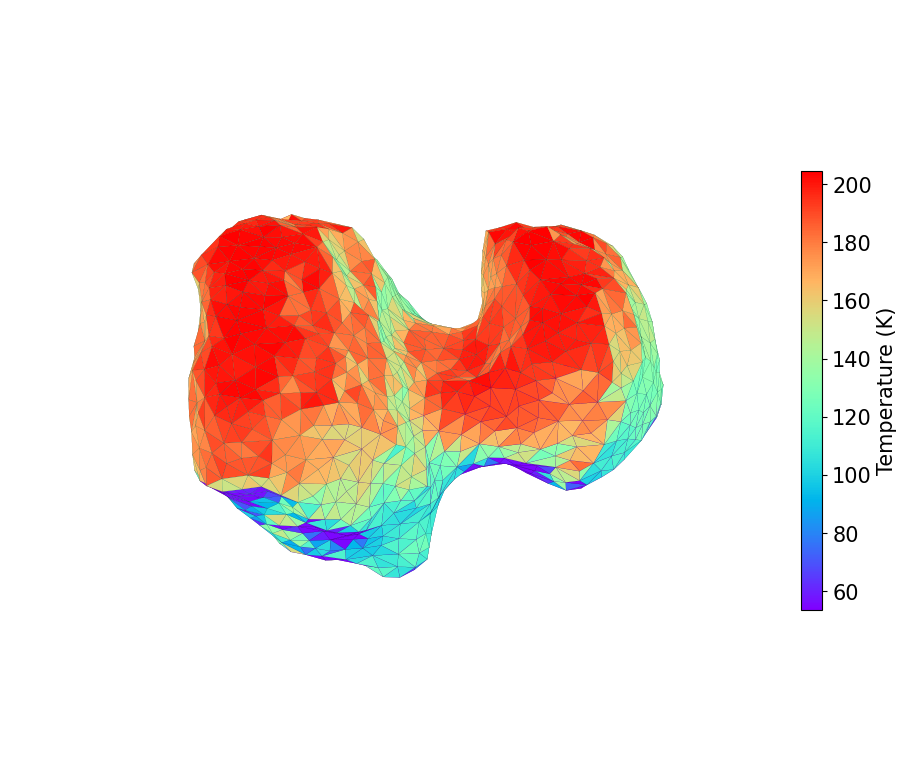

In [12]:
# Plot subsurface temperature
tem0 = tem[5].reshape(len(surface_element), 1)
min_val = np.min(tem0)
max_val = np.max(tem0)

colors = cm.rainbow((tem-min_val)/(max_val-min_val))[:, 0, :3]*255

si = 15
si1 = 0.03
si2 = 0.57
si3 = 'vertical'
points = surface_element

fig = plt.figure(figsize=(12, 10))

a = tem0
min_val = np.min(a)
max_val = np.max(a)

ax1 = fig.add_subplot(1, 1, 1, projection='3d')
colors = cm.rainbow((a-min_val)/(max_val-min_val))[:, 0, :3]
for i in range(len(points)):
    vertices = [points[i]]
    poly = Poly3DCollection(vertices, facecolors=[colors[i]], edgecolors='black', linewidth=0.05)
    ax1.add_collection3d(poly)
    
norm = Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap=cm.rainbow, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax1, orientation=si3, pad=si1, shrink=si2)
cbar.set_label('Temperature (K)', fontsize=si)
cbar.ax.tick_params(labelsize=si)

x_min, x_max = surface_element[:, :, 0].min(), surface_element[:, :, 0].max()
y_min, y_max = surface_element[:, :, 1].min(), surface_element[:, :, 1].max()
z_min, z_max = surface_element[:, :, 2].min(), surface_element[:, :, 2].max()

si0 = 20
ax1.set_xlabel('X (km)', fontsize=si, labelpad=si0)
ax1.set_ylabel('Y (km)', fontsize=si, labelpad=si0)
ax1.set_zlabel('Z (km)', fontsize=si, labelpad=si0)

ax1.tick_params(labelsize=si)
ax1.set_xlim3d([x_min, x_max])
ax1.set_ylim3d([y_min, y_max])
ax1.set_zlim3d([z_min, z_max])
ax1.set_aspect('equal')
ax1.view_init(elev=20, azim=42-160)
ax1.set_facecolor('none')

ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.xaxis._axinfo["grid"]['color'] =  (0, 0, 0, 0)

ax1.grid(False)
ax1.set_axis_off()

plt.show()